DNN testing playground! 

i wanna put all the final shit for the DNN into a .py file but for now while I fuck with stuff, ill do it here. that is if this bad boi can even handle the big ass .h5py files I made, if not either make smaller ones or just use alpha.

In [1]:
# boilerplate, ensure you have these packages
import numpy as np
import tensorflow as tf
from keras import callbacks
from keras.callbacks import LearningRateScheduler as LRS
from keras.models import Model
from keras.layers import *
from keras import optimizers as kopt
import keras.backend as K
import keras as k
import datetime
import h5py
import hyperopt as hopt
import re
import fnmatch as fm

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 907726805916145777
]


In [2]:
# data rescaling functions, want everything to be [0,1]
# rescaling thicknesses, angle of incid, psi, delta
# this info should be pulled from the corresponding .txt file!!!
# ^although im not quite sure how I wanna do tht rn so just list it in the .txt file
def resc_l(thickness):
    'rescales the thicknesses to [0,1], takes in arrays'
    resc = thickness*1e7 
    return resc
def resc_ang(aoi):
    'rescales the aoi to [0,1], takes in arrays in DEGREES'
    resc = aoi/90.
    return resc
def resc_psi(psi):
    '''
    rescales ellipsometric coeff psi to basically [0,1], takes in array in DEGREES. returns in rescaled degrees
    '''
    resc = psi/90.
    return resc
def resc_del(delta):
    '''
    rescales ellipsometric coeff delta to be positive (by adding phase shift if needed)
    takes in array in RADIANS (b/c its the natural output of tmm.ellips). returns rescaled degrees
    '''
    if (delta.min()<0.):
        resc = delta + np.pi
    resc = np.rad2deg(resc)/360.
    return resc

In [3]:
# learning rate decay function
def decay(ep):
    'learning rate decay function, input is epochs, may not actually be used since i dont have live update guy'
    a = .0025
    lr = a/((ep)+1)
    return lr
lr = LRS(decay)


In [4]:
# funct to read in data
def read_dat(fname,dataset,nlay,nang,nwvl):
    '''
    function to read in the training data within an .h5 file and rescale
    currently used for ENZ proj with data for angle, thicknesses, rp, rs, tp, ts, psi, delta
    NOTE: data should be a [N,T] array, w/ N for num of runs and T = nang + nlay + 6*nang*nwvl
    inputs:
    fname - string - file name containing the training data, pls use full file name
    dataset - string - name of the dataset in the .h5 file
    NOTE: currently doesn't support reading in data from more than 1 dataset
    nlay - integer - number of layers in the multistack
    nang - integer - number of angles of incidence investigated
    nwvl - integer - number of wavelengths investigated
    NOTE: will throw errors if inputs are not correct
    outputs:
    ang - array, float - [N,nang] array of rescaled angles
    l - array, float - [N,nlay] array of rescaled thicknesses
    rp,rs,tp,ts - array, float - each is a [N,nang*nwvl] array of R and T params
    psi, delta - array, float - each is a [N,nang*nwvl] array of ellipsometric coeff in degrees
    '''
    # assertions to make sure inputs are good
    assert isinstance(nang,int), 'incorrect input for: nang'
    assert isinstance(nlay,int), 'incorrect input for: nlay'
    assert isinstance(nwvl,int), 'incorrect input for: nwvl'
    assert isinstance(fname,str), 'incorrect input for: fname'
    assert isinstance(dataset,str), 'incorrect input for: dataset'
    with h5py.File(fname,'r') as h:
        dat = np.array(h.get(dataset))
    # assertion to make sure this will read in data correctly
    assert (dat[0,0,:].size == nang+nlay+6*nang*nwvl), 'total data shape and input shape do not match'
    ang = dat[:,0,0:nang]
    l = dat[:,0,nang:(nang+nlay)]
    high = nang+nlay+nang*nwvl
    rp = dat[:,0,(nang+nlay):high]
    low = high
    high += nang*nwvl
    rs = dat[:,0,low:high]
    low = high
    high += nang*nwvl
    tp = dat[:,0,low:high]
    low = high
    high += nang*nwvl
    ts = dat[:,0,low:high]
    low = high
    high += nang*nwvl
    psi = dat[:,0,low:high]
    low = high
    high += nang*nwvl
    delta = dat[:,0,low:high]
    # assertion to make sure data was read in correctly
    assert (dat[-1,0,-1]==delta[-1,-1]), 'data was read incorrectly'
    # delete the original array that was read in as it is just a space waster now
    del dat
    l = resc_l(l)
    ang = resc_ang(ang)
    psi = resc_psi(psi)
    # to make sure phase shift is introduced correctly, need to seperate delta by angle
    if (nang>1):
        for i in range(nang):
            delta[:,(i*nwvl):((i+1)*nwvl)] = resc_del(delta[:,(i*nwvl):((i+1)*nwvl)])
    delta = resc_del(delta)
    return (ang,l,rp,rs,tp,ts,psi,delta)

In [5]:
# function that combines 'read_dat' and 'split_dat'
def rs_dat(fname,dataset,nlay,nang,nwvl,n_tr,n_te,input_names,tr_dict,te_dict):
    '''
    function to read the data from the .h5 file with 'read_dat'
    and then split it into training and testing dictionaries
    note: currently using Keras' Model.fit 'validation_split' function for validation dat
    ^ but still want a 90%,5%,5% split btwn training, validation, and testing
    and should throw errors if things go wrong
    inputs:
    fname - string - file name containing the training data, pls use full file name
    dataset - string - name of the dataset in the .h5 file
    NOTE: currently doesn't support reading in data from more than 1 dataset
    nlay - integer - number of layers in the multistack
    nang - integer - number of angles of incidence investigated
    nwvl - integer - number of wavelengths investigated
    n_tr - integer - number of sets for training
    n_te - integer - number of sets for testing
    input_names = array, strings - array with the names of the input tensors of your model to fill the dictionaries
    ^ useful for this and to make sure the model construction function is correct
    tr_dict/te_dict - dictionary - dict's that can be used as inputs in keras' Model.fit/evaluate
    ^ should be empty, and will only work if use 'build_mod'
    outputs:
    tr_dict/te_dict - dictionary - the dictionaries containing the correctly split up data for training/validation
    trl/tel - array, float - the arrays of the 
    (tr_dict,te_dict,trl,tel) - tuple dictionaries  - the dictionaries containing the correctly split up data for training/validation
    ^ dict keys will be in the same order that the input layers were created
    '''
    # read in data
    (ang,l,rp,rs,tp,ts,psi,delta) = read_dat(fname,dataset,nlay,nang,nwvl)
    # assert good splits and take care of thicknesses
    assert (n_tr+n_te == ang.shape[0]), 'error: invalid split btwn training/testing'
    trl = l[:n_tr,:]
    tel = l[n_tr:,:]
    # removing outputs from 'read_dat' once their data is where it needs to be
    del l
    # check the dictionaries are empty
    assert (len(tr_dict)==len(te_dict)==0), 'error: non-empty dictionaries, please empty and try again'
    # fill the dict with the names and give them a placeholder array of the correct size
    a = 0
    b = 0
    I = len(input_names)//nang
    while (a<len(input_names)):
        tr_dict[input_names[a]] = np.zeros((n_tr,(ang,rp,rs,tp,ts,psi,delta)[b].shape[1]//nang))
        te_dict[input_names[a]] = np.zeros((n_te,(ang,rp,rs,tp,ts,psi,delta)[b].shape[1]//nang))
        a += 1
        if (b<(I-1)):
            b += 1
        else:
            b = 0
    # for checking data was loaded in correctly b/c dictionary items are changable
    bef1 = np.array([tr_dict[key].shape for key in tr_dict])
    bef2 = np.array([te_dict[key].shape for key in te_dict])
    # put the data in the bag (dict), PUT IT IN, props if you get this
    a = 0
    b = 0
    c = 0
    for key in tr_dict:
        x = (tr_dict[key].shape[1])
        if re.search('1',key):
            tr_dict[key] = (ang,rp,rs,tp,ts,psi,delta)[a][:n_tr,0:x]
            te_dict[key] = (ang,rp,rs,tp,ts,psi,delta)[a][n_tr:,0:x]
            a += 1
        elif re.search('2',key):
            tr_dict[key] = (ang,rp,rs,tp,ts,psi,delta)[b][:n_tr,x:(2*x)]
            te_dict[key] = (ang,rp,rs,tp,ts,psi,delta)[b][n_tr:,x:(2*x)]
            b += 1
        else:
            tr_dict[key] = (ang,rp,rs,tp,ts,psi,delta)[c][:n_tr,(2*x):]
            te_dict[key] = (ang,rp,rs,tp,ts,psi,delta)[c][n_tr:,(2*x):]
            c += 1
    # remove the rest of the data from memory
    # del ang; del rp; del rs; del tp; del ts; del psi; del delta
    # check if items were changed
    aft1 = np.array([tr_dict[key].shape for key in tr_dict])
    aft2 = np.array([te_dict[key].shape for key in te_dict])
    assert (np.all(bef1==aft1)), 'error: shape mismatch after data was loaded into the training dict'
    assert (np.all(bef2==aft2)), 'error: shape mismatch after data was loaded into the testing dict'
    return (trl,tel,tr_dict,te_dict)

In [6]:
# input names, since i can use a dict for training and testing
input_names = np.array(['angle_1','rp_1','rs_1','tp_1','ts_1','psi_1','delta_1','angle_2','rp_2','rs_2','tp_2','ts_2','psi_2','delta_2','angle_3','rp_3','rs_3','tp_3','ts_3','psi_3','delta_3'])

In [7]:
wvl = np.linspace(400.,1000,121)
nwvl = len(wvl)
nlay = 15
nang = 3
n_tr = 450
n_te = 50
tr_dict = dict()
te_dict = dict()
fname = 'traindata_enzchar_lay15_mats3_n0.5k_20210216.hdf5'

In [8]:
(trl,tel,tr_dict,te_dict) = rs_dat(fname,'data',nlay,nang,nwvl,n_tr,n_te,input_names,tr_dict,te_dict)

In [9]:
# heres the model babey
# make an input for the input names to run an assert and make sure they match
def build_mod(drop,nwvl,act='relu',input_names=None):
    '''
    builds a DNN model that can be used for machine learing
    currently takes the inputs based by angle, does the DNN thing and should be outputting
    the thicknesses of each layer in the multistack.
    currently assuming there are three aoi's
    input:
    drop - float - dropout rate can be (0,1) exclusive
    nwvl - integer - number of wavelengths investigated
    act - string - activation method for Dense layer, default 'relu', see keras Dense documentation for more options
    ^ NOTE: this is for the inner Dense layers the ones at the end can/will be different
    input_names = array, strings - array with the names of the input tensors of your model
    ^ default is None, however using this feature ensures compatibility btwn your model and dictionaries, before model is compiled
    output:
    model - model obj - a full fledged keras model, it has ONLY BEEN MADE, needs to be compiled and named
    '''
    # inputs are grouped by aoi
    a1 = Input((1,),name='angle_1')
    rp1 = Input((nwvl,),name='rp_1'); rs1 = Input((nwvl,),name='rs_1')
    tp1 = Input((nwvl,),name='tp_1'); ts1 = Input((nwvl,),name='ts_1')
    p1 = Input((nwvl,),name='psi_1'); d1 = Input((nwvl,),name='delta_1')
    a2 = Input((1,),name='angle_2')
    rp2 = Input((nwvl,),name='rp_2'); rs2 = Input((nwvl,),name='rs_2')
    tp2 = Input((nwvl,),name='tp_2'); ts2 = Input((nwvl,),name='ts_2')
    p2 = Input((nwvl,),name='psi_2'); d2 = Input((nwvl,),name='delta_2')
    a3 = Input((1,),name='angle_3')
    rp3 = Input((nwvl,),name='rp_3'); rs3 = Input((nwvl,),name='rs_3')
    tp3 = Input((nwvl,),name='tp_3'); ts3 = Input((nwvl,),name='ts_3')
    p3 = Input((nwvl,),name='psi_3'); d3 = Input((nwvl,),name='delta_3')
    # connect the inputs
    # currently im thinking connecting them in a similar fasion as the rows
    # these are midpoints and so shall be named: m##, 1st #: layer num, 2nd #: index within layer
    # note: add layer makes a tensor of the same size of the inputs but idk how tht works if they arent the same size so im just doing it like andy for rn
    m11 = Add()([a1,rp1,rs1]); m12 = Add()([a1,tp1,ts1]); m13 = Add()([a1,p1,d1])
    m14 = Add()([a2,rp2,rs2]); m15 = Add()([a2,tp2,ts2]); m16 = Add()([a2,p2,d2])
    m17 = Add()([a3,rp3,rs3]); m18 = Add()([a3,tp3,ts3]); m19 = Add()([a3,p3,d3])
    # dense layer, followed by a dropout
    # name scheme: x##: 1st #: dense layer num, 2nd #: index within layer
    x11 = Dense(nwvl,activation=act)(m11); x11 = Dropout(drop)(x11)
    x12 = Dense(nwvl,activation=act)(m12); x12 = Dropout(drop)(x12)
    x13 = Dense(nwvl,activation=act)(m13); x13 = Dropout(drop)(x13)
    x14 = Dense(nwvl,activation=act)(m14); x14 = Dropout(drop)(x14)
    x15 = Dense(nwvl,activation=act)(m15); x15 = Dropout(drop)(x15)
    x16 = Dense(nwvl,activation=act)(m16); x16 = Dropout(drop)(x16)
    x17 = Dense(nwvl,activation=act)(m17); x17 = Dropout(drop)(x17)
    x18 = Dense(nwvl,activation=act)(m18); x18 = Dropout(drop)(x18)
    x19 = Dense(nwvl,activation=act)(m19); x19 = Dropout(drop)(x19)
    # another Add layer, now m2#, combining all data from each aoi together
    m21 = Add()([x11,x12,x13])
    m22 = Add()([x14,x15,x16])
    m23 = Add()([x17,x18,x19])
    # another Dense layer, also followed by a dropout 
    # name now x2#, also increase output size
    x21 = Dense((nwvl+50),activation=act)(m21); x21 = Dropout(drop)(x21)
    x22 = Dense((nwvl+50),activation=act)(m22); x22 = Dropout(drop)(x22)
    x23 = Dense((nwvl+50),activation=act)(m23); x23 = Dropout(drop)(x23)
    # another Add layer, now m3#, combining all data together
    m31 = Add()([x21,x22,x23])
    # another dense layer with dropout after, now x3#
    x31 = Dense((nwvl+100),activation=act)(m31)
    x31 = Dropout(drop)(x31)
    # last 'internal' layer, prep for output layer
    # note: i have no idea what the output for this layer should be, consult andy
    x41 = Dense(100,activation=act)(x31)
    # output layer
    # note: no idea what the activation should be for this one, consult andy
    l_out = Dense(15,activation=None)(x41)
    # checking if inputs match (if possible), and putting the model together
    model = Model([a1,rp1,rs1,tp1,ts1,p1,d1,a2,rp2,rs2,tp2,ts2,p2,d2,a3,rp3,rs3,tp3,ts3,p3,d3],[l_out])
    if (np.all(input_names==None)):
        print('have fun doing inputs by hand my friend')
    elif (hasattr(input_names,'T')):
        # only use names from input layers
        check_names = np.array([layer.name for layer in model.layers if (re.search('add|dense|dropout',layer.name)==None) and (np.any(input_names==layer.name)==True)])
        assert (len(check_names)==len(input_names)), 'error: mismatch btwn #/elements in input_names and input tensors'
        print('congrats you can be lazy and just pass your dictionaries into the model and let keras figure it out')
    else:
        raise Exception('input_names has incompatible form')
    return model

In [10]:
drop = 0.

In [11]:
mod = build_mod(drop,nwvl,input_names=input_names)
# compiling the same way as andy rn
mod.compile(optimizer='adam',loss=['mse'],metrics=['mse','accuracy'],loss_weights=[10])
modname = 'enzchar_invdes_model_d21621.h5'




congrats you can be lazy and just pass your dictionaries into the model and let keras figure it out



In [12]:
mod.save(modname)

In [13]:
# mod.summary()



Train on 405 samples, validate on 45 samples
Epoch 1/5
 - 4s - loss: 10.5935 - mean_squared_error: 1.0594 - acc: 0.0938 - val_loss: 0.7994 - val_mean_squared_error: 0.0799 - val_acc: 0.1778
Epoch 2/5
 - 0s - loss: 0.4056 - mean_squared_error: 0.0406 - acc: 0.1358 - val_loss: 0.2625 - val_mean_squared_error: 0.0263 - val_acc: 0.2000
Epoch 3/5
 - 0s - loss: 0.2183 - mean_squared_error: 0.0218 - acc: 0.1580 - val_loss: 0.1921 - val_mean_squared_error: 0.0192 - val_acc: 0.2222
Epoch 4/5
 - 0s - loss: 0.1780 - mean_squared_error: 0.0178 - acc: 0.2247 - val_loss: 0.1864 - val_mean_squared_error: 0.0186 - val_acc: 0.2222
Epoch 5/5
 - 0s - loss: 0.1699 - mean_squared_error: 0.0170 - acc: 0.2617 - val_loss: 0.1751 - val_mean_squared_error: 0.0175 - val_acc: 0.2222
[0.18418414950370787, 0.018418415226042272, 0.26000000357627867]


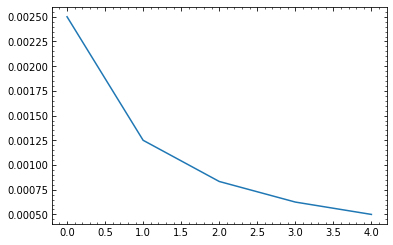

In [14]:
# put the data in the model, use the meatgrinder
history = mod.fit(tr_dict,trl,epochs=5,verbose=2,validation_split=.1,callbacks=[lr])
# usually you save after this
# mod.save(modname) # but i dont wanna
# eval and print stats on fit
mod_loss = mod.evaluate(te_dict,tel,verbose=2)
print(mod_loss)
plt.plot(history.history['lr']);